<a href="https://colab.research.google.com/github/Qi-He1/stats507-coursework/blob/main/22Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch pandas matplotlib seaborn scikit-learn

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import traceback

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 1. Load and explore the dataset

In [ ]:
dataset = load_dataset("GonzaloA/fake_news")

print(f"Dataset structure: {dataset}")
print(f"Available splits: {list(dataset.keys())}")

print("\n=== Data Distribution ===")
for split_name in dataset.keys():
    labels = dataset[split_name]['label']
    fake_count = sum(1 for label in labels if label == 0)
    real_count = sum(1 for label in labels if label == 1)
    print(f"{split_name} set - Fake news: {fake_count}, Real news: {real_count}, Total: {len(labels)}")

final_dataset = {
    'train': dataset['train'],
    'validation': dataset['validation'],
    'test': dataset['test']
}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 24353
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
})
Available splits: ['train', 'validation', 'test']

=== Data Distribution ===
train set - Fake news: 11158, Real news: 13195, Total: 24353
validation set - Fake news: 3723, Real news: 4394, Total: 8117
test set - Fake news: 3782, Real news: 4335, Total: 8117


# 2. Define model configurations and global variables

In [ ]:
MODELS = {
    "distilbert": "distilbert-base-uncased",
    "bert": "google-bert/bert-base-uncased",
    "roberta": "FacebookAI/roberta-base"
}

all_results = {}

# 3. Define model training and evaluation function

In [ ]:
def train_and_evaluate_model(model_name, model_path):

    print(f"Starting {model_name.upper()} model")
    start_time = time.time()

    # Load tokenizer
    print(f"Loading {model_name} tokenizer...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    except Exception as e:
        print(f"Failed to load tokenizer: {e}")
        return None

    # For RoBERTa, set pad_token
    if model_name == "roberta" and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Define preprocessing function
    def preprocess_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors=None
        )

    # Tokenize datasets
    print("Tokenizing text...")
    tokenized_datasets = {}
    for split in ['train', 'validation', 'test']:
        tokenized_datasets[split] = final_dataset[split].map(
            preprocess_function,
            batched=True,
            batch_size=1000
        )

        # Rename label column to match Hugging Face format
        if 'label' in tokenized_datasets[split].column_names:
            tokenized_datasets[split] = tokenized_datasets[split].rename_column('label', 'labels')

    # Create model
    print(f"Initializing {model_name} model...")
    model_config = {
        "num_labels": 2,
        "id2label": {0: "fake", 1: "real"},
        "label2id": {"fake": 0, "real": 1}
    }

    # Special handling for RoBERTa
    if model_name == "roberta":
        model_config["pad_token_id"] = tokenizer.pad_token_id

    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            **model_config
        )
    except Exception as e:
        print(f"Failed to load model: {e}")
        return None

    # Define evaluation metrics calculation function for training validation
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        pred_labels = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(labels, pred_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, pred_labels, average='binary'
        )

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    # Set training arguments (use accuracy as the best model metric)
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}-fake-news",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name}",
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        seed=42,
        report_to=None,
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train model
    print(f"Training {model_name} model...")
    try:
        train_result = trainer.train()

        # Record training time
        end_time = time.time()
        training_time = end_time - start_time
        print(f"{model_name} training time: {training_time:.2f} seconds")

    except Exception as e:
        print(f"Training failed: {e}")
        traceback.print_exc()
        return None

    # Final evaluation on test set
    print(f"Evaluating {model_name} model on test set...")
    test_predictions = trainer.predict(tokenized_datasets["test"])

    # Extract prediction results
    predictions = test_predictions.predictions
    true_labels = test_predictions.label_ids
    predictions_proba = torch.softmax(torch.tensor(predictions), dim=-1).numpy()
    pred_labels = np.argmax(predictions, axis=1)

    # Calculate all evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='binary'
    )

    fpr, tpr, thresholds = roc_curve(true_labels, predictions_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(true_labels, pred_labels)

    print(f"\n=== {model_name.upper()} Test Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Save results
    model_results = {
        'test_metrics': {
            'test_accuracy': accuracy,
            'test_f1': f1,
            'test_precision': precision,
            'test_recall': recall
        },
        'training_time': training_time,
        'confusion_matrix': cm.tolist(),
        'roc_curve': {
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist(),
            'auc': roc_auc
        }
    }

    # Save model
    trainer.save_model(f"./models/{model_name}-final")
    tokenizer.save_pretrained(f"./models/{model_name}-final")
    print(f"\n{model_name} model saved to './models/{model_name}-final'")

    return model_results


# 4. Train all models

In [ ]:
successful_models = []
for model_name, model_path in MODELS.items():
    print(f"\nProcessing model: {model_name.upper()}")
    result = train_and_evaluate_model(model_name, model_path)

    if result is not None:
        all_results[model_name] = result
        successful_models.append(model_name)
        print(f" {model_name.upper()} model training completed")
    else:
        print(f" {model_name.upper()} model training failed")

print(f"\nSuccessfully trained models: {[m.upper() for m in successful_models]}")


Processing model: DISTILBERT
Starting DISTILBERT model
Loading distilbert tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing text...


Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Initializing distilbert model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-224659476.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training distilbert model...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: heqi030424 (heqi030424-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.027500,0.029812,0.987311,0.998143,0.978380,0.988162
2,0.016200,0.036992,0.988789,0.990874,0.988393,0.989632
3,0.011300,0.046102,0.988666,0.988420,0.990669,0.989543


distilbert training time: 1720.95 seconds
Evaluating distilbert model on test set...



=== DISTILBERT Test Results ===
Accuracy: 0.9889
F1 Score: 0.9896
AUC-ROC: 0.9996
Precision: 0.9910
Recall: 0.9882

distilbert model saved to './models/distilbert-final'
 DISTILBERT model training completed

Processing model: BERT
Starting BERT model
Loading bert tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizing text...


Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Initializing bert model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-224659476.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training bert model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.043700,0.044758,0.985216,0.998833,0.973828,0.986172
2,0.020900,0.045206,0.986571,0.986158,0.989076,0.987615
3,0.034900,0.044647,0.988050,0.987963,0.989986,0.988974


bert training time: 3348.99 seconds
Evaluating bert model on test set...



=== BERT Test Results ===
Accuracy: 0.9871
F1 Score: 0.9879
AUC-ROC: 0.9995
Precision: 0.9889
Recall: 0.9869

bert model saved to './models/bert-final'
 BERT model training completed

Processing model: ROBERTA
Starting ROBERTA model
Loading roberta tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizing text...


Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Initializing roberta model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-224659476.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training roberta model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.046000,0.038331,0.981151,0.999764,0.965407,0.982286
2,0.043200,0.047329,0.980165,0.996948,0.966318,0.981394
3,0.025800,0.034359,0.985093,0.989237,0.983159,0.986189


roberta training time: 3335.17 seconds
Evaluating roberta model on test set...



=== ROBERTA Test Results ===
Accuracy: 0.9844
F1 Score: 0.9853
AUC-ROC: 0.9994
Precision: 0.9907
Recall: 0.9799

roberta model saved to './models/roberta-final'
 ROBERTA model training completed

Successfully trained models: ['DISTILBERT', 'BERT', 'ROBERTA']


# 5. Result comparison and visualization


Detailed Performance Comparison:
     Model Accuracy F1-Score AUC-ROC Precision Recall Training_Time(s)
DISTILBERT   0.9889   0.9896  0.9996    0.9910 0.9882          1720.95
      BERT   0.9871   0.9879  0.9995    0.9889 0.9869          3348.99
   ROBERTA   0.9844   0.9853  0.9994    0.9907 0.9799          3335.17


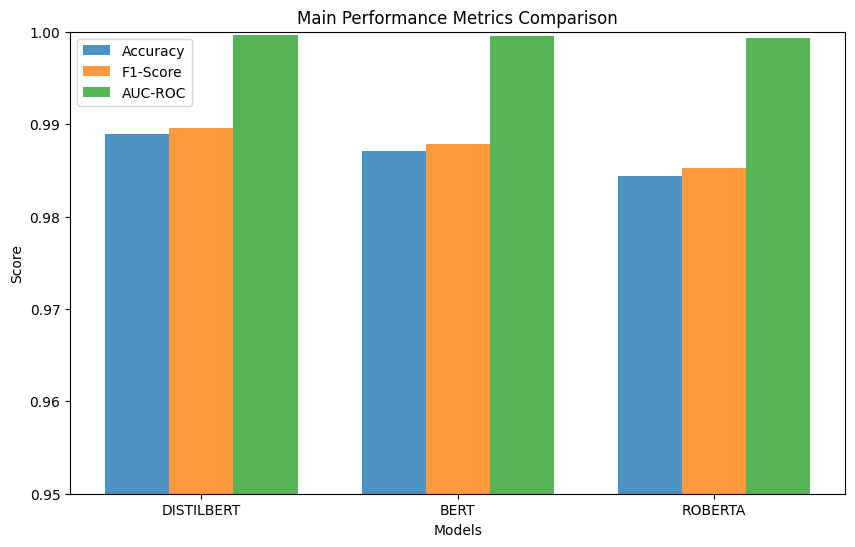

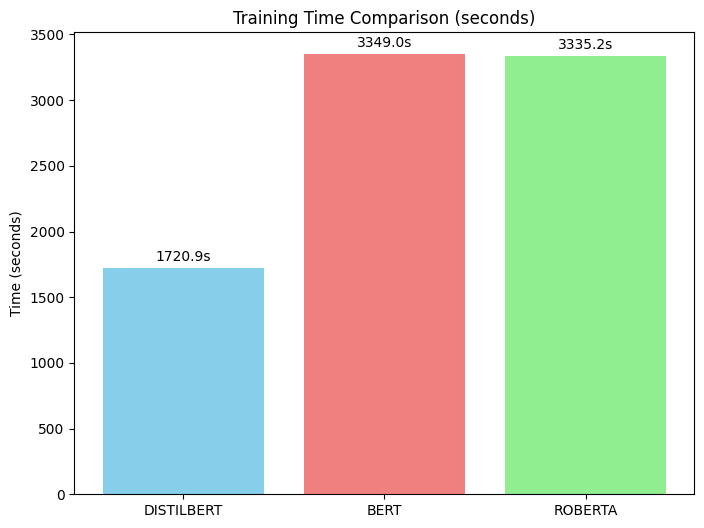

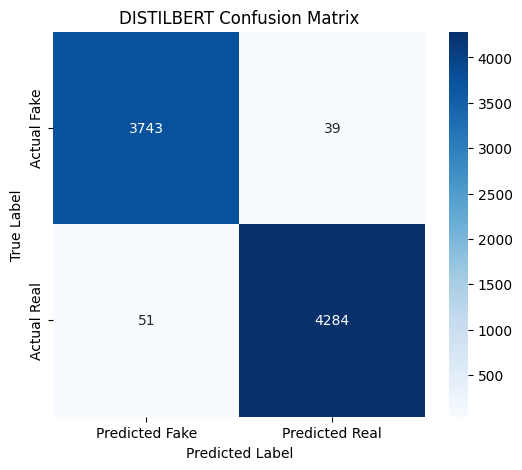

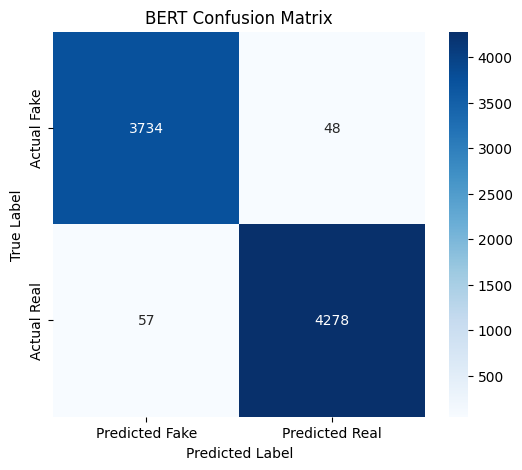

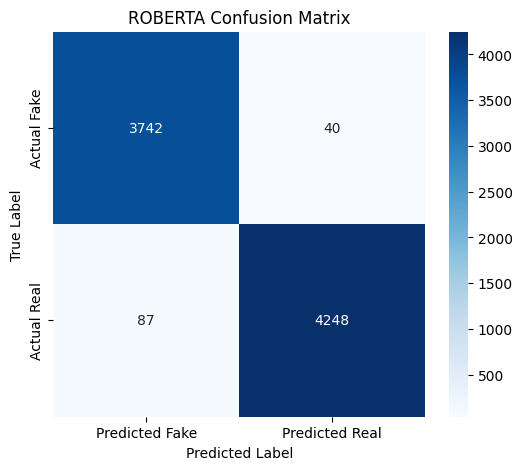

In [ ]:
# Create comparison table
comparison_data = []
for model_name, results in all_results.items():
    test_metrics = results['test_metrics']
    training_time = results['training_time']
    roc_auc = results['roc_curve']['auc']

    comparison_data.append({
        'Model': model_name.upper(),
        'Accuracy': f"{test_metrics.get('test_accuracy', 0):.4f}",
        'F1-Score': f"{test_metrics.get('test_f1', 0):.4f}",
        'AUC-ROC': f"{roc_auc:.4f}",
        'Precision': f"{test_metrics.get('test_precision', 0):.4f}",
        'Recall': f"{test_metrics.get('test_recall', 0):.4f}",
        'Training_Time(s)': f"{training_time:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nDetailed Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualization results
# 1. Main performance metrics comparison plot
plt.figure(figsize=(10, 6))
metrics_to_plot = ['Accuracy', 'F1-Score', 'AUC-ROC']
metric_values = {metric: [] for metric in metrics_to_plot}

for model_name in all_results.keys():
    test_metrics = all_results[model_name]['test_metrics']
    roc_auc = all_results[model_name]['roc_curve']['auc']

    for metric in metrics_to_plot:
        if metric == 'F1-Score':
            key = 'test_f1'
            metric_values[metric].append(float(test_metrics.get(key, 0)))
        elif metric == 'AUC-ROC':
            metric_values[metric].append(float(roc_auc))
        else:
            key = 'test_accuracy'
            metric_values[metric].append(float(test_metrics.get(key, 0)))

x = np.arange(len(all_results))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, metric_values[metric], width, label=metric, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Main Performance Metrics Comparison')
plt.xticks(x + width, [model.upper() for model in all_results.keys()])
plt.legend()
plt.ylim(0.95, 1)
plt.show()

# 2. Training time and efficiency comparison
plt.figure(figsize=(8, 6))
training_times_list = [all_results[model]['training_time'] for model in all_results.keys()]
plt.bar([model.upper() for model in all_results.keys()], training_times_list,
        color=['skyblue', 'lightcoral', 'lightgreen'][:len(all_results)])
plt.title('Training Time Comparison (seconds)')
plt.ylabel('Time (seconds)')

for i, v in enumerate(training_times_list):
    plt.text(i, v + max(training_times_list)*0.01, f'{v:.1f}s', ha='center', va='bottom')
plt.show()

# 3. Confusion matrix heatmap
model_names = list(all_results.keys())
for model_name in model_names:
    plt.figure(figsize=(6, 5))
    cm = np.array(all_results[model_name]['confusion_matrix'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Fake', 'Predicted Real'],
                yticklabels=['Actual Fake', 'Actual Real'])
    plt.title(f'{model_name.upper()} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()